In [1]:
import numpy as np
import scipy as sp
import heartpy as hp
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from biosppy.signals import ecg
import hvr
import wave_morph as wm
from scipy import signal

%matplotlib inline

# Waveform Morphology
## What do waveforms look like? Do they differ in their peaks? How do ECG and PPG waveforms relate to eachother?
In this notebook I attempt to assess various measures that are loosely defined as assessing the waveform morphology taken from ECG and PPG signals

In [2]:
#Produces dataframes and arrays for each csv file and adds to dictionaries

import glob, os

#Produce each peak dataframe
dfs = {}
peak_dfs = {}
ecg_sigs = {}
ppg_sigs = {}
ts = {}
class_labels = {}
for file in glob.glob('*.csv'):
    
    #String to save as key in dictionaries
    name_pre = file.split()[2]
    
    if 'hyper' in file.lower():
        f_class = 1
    elif 'norm' in file.lower():
        f_class = 0
    elif 'hypo' in file.lower():
        f_class = -1
    else:
        f_class = np.nan
    
    if 'D46' in file:
        fs = 500
    else:
        fs = 250
       
    df = pd.read_csv(file)
    
    #Adds values to dataframe
    dfs[name_pre] = df
    peak_dfs[name_pre] = hvr.get_ppg_peaks(file,fs)
    ecg_sigs[name_pre] = np.array(df['ecg'])
    ppg_sigs[name_pre] = np.array(df['ppg'])
    ts[name_pre] = np.array(df['time']) 
    class_labels[name_pre] = f_class

### Let's have a look at PPG peaks relative to ECG peaks as this is important in identifying peaks from noisy ECG signals

[]

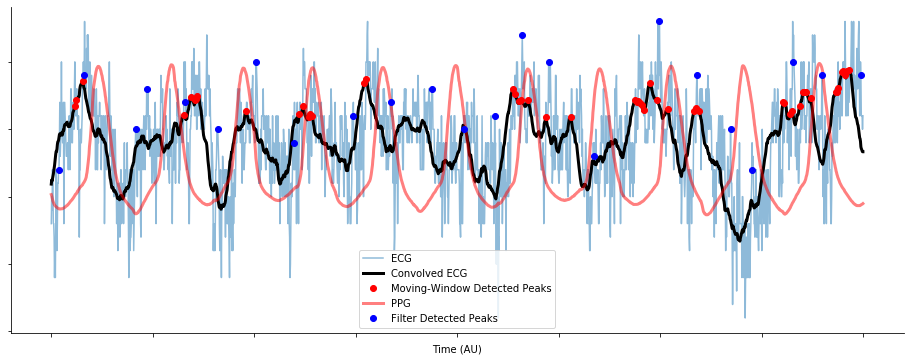

In [3]:
##### --- Peak Plotter ----  #####

ecg_sig = ecg_sigs['D45']
ppg_sig = ppg_sigs['D45']

# process it and plot
out = ecg.ecg(signal=ecg_sig, sampling_rate=250, show=False)

t_range = (4000,6000)

fig = plt.figure(figsize=(16,6))
plt.plot(ecg_sig[t_range[0]:t_range[1]],alpha=0.5,label='ECG')

#Moving window average
N=30 #Size of window
ecg_mwa = np.convolve(ecg_sig, np.ones(N)/N, mode='valid') #Convolved signal

h_th = np.average(ecg_mwa) + np.std(ecg_mwa)

#Find negative peak positions
ecg_peaks = signal.find_peaks(ecg_mwa,height=h_th)

plt.plot(ecg_mwa[t_range[0]:t_range[1]],linewidth=3,color='black',label='Convolved ECG')
plt.plot(ecg_peaks[0][(ecg_peaks[0]>t_range[0]) & (ecg_peaks[0]<t_range[1])] - t_range[0],
         ecg_mwa[ecg_peaks[0][(ecg_peaks[0]>t_range[0]) & (ecg_peaks[0] < t_range[1])]],'ro',
         label='Moving-Window Detected Peaks')


#Scale PPG to fit with ECG signal
sig_ran = max(ppg_sig) - min(ppg_sig)
ppg_scale = (ppg_sig - min(ppg_sig)) / sig_ran
ran2 = 1960 - 1940
ppg_scale = (ppg_scale * ran2) + 1940
plt.plot(ppg_scale[t_range[0]:t_range[1]],color='r',alpha=0.5,linewidth='3',label='PPG')

plt.plot(out['rpeaks'][(out['rpeaks']>t_range[0]) & (out['rpeaks']<t_range[1])] - t_range[0],
         ecg_sig[out['rpeaks'][(out['rpeaks']>t_range[0]) & (out['rpeaks']<t_range[1])]],'bo',
         label='Filter Detected Peaks')

plt.xlabel('Time (AU)')
plt.legend()
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
ax.set_yticklabels([])
ax.set_xticklabels([])

### By using the convolution method we can get a rough estimate for PAT (Pulse-Arrival Time)

In [4]:
#Compute PAT arrays and add to dict
PATs = {}
for key,value in peak_dfs.items():
    
    #Compute a PAT array
    PAT = wm.MW_PAT_Estimate(ecg_sigs[key],peak_dfs[key],ts[key])
    
    if class_labels[key] == -1:
        continue
    else:
        PATs[key] = PAT

In [5]:
def plot_bar(dict_arrays,title):
    '''
    Plots a bar chart from a dictionary of arrays
    '''
    #Bar charts of PAT
    norm_means = [np.nanmean(dict_arrays['D46'])/1000, np.nanmean(dict_arrays['D45'])/1000]
    hyp_means = [np.nanmean(dict_arrays['D44'])/1000, np.nanmean(dict_arrays['D43'])/1000]

    means = [np.mean(norm_means), np.mean(hyp_means)]
    sems = [np.std(norm_means)/np.sqrt(len(norm_means)),
            np.std(hyp_means)/np.sqrt(len(hyp_means))]


    fig = plt.figure(figsize=(4,5))
    plt.bar([0,1],means,yerr=sems,tick_label=['Normotension','Hypertension'],
                    color=['black','red'],alpha=0.8)
    plt.ylabel(title)
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    

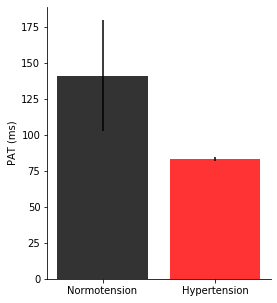

In [6]:
plot_bar(PATs,'PAT (ms)')

### Slope-traversal time (STT) has been associated with PAT but only requires a PPG signal. Let's check that out.

In [7]:
#Compute STT arrays and add to dict
STTs = {}
for key,value in peak_dfs.items():
    
    #Compute a PAT array
    STT = wm.STT(ppg_sigs[key],ts[key],peak_dfs[key])
    
    if class_labels[key] == -1:
        continue
    else:
        STTs[key] = STT

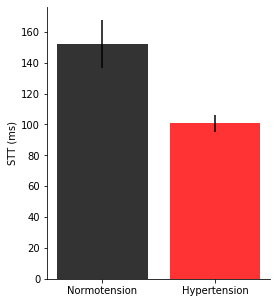

In [8]:
plot_bar(STTs,'STT (ms)')

In [9]:
def moving_window_func(arr,win,step):
    '''
    Moving window function expressed in samples rather than time
    '''
    w_list = list()
    n_records = len(arr)
    remainder = (n_records - win) % step 
    num_windows = 1 + int((n_records - win - remainder) / step)
    for k in range(num_windows):
        w_list.append(arr[k*step:win-1+k*step+1])
    return np.array(w_list)

In [32]:
from scipy.ndimage import gaussian_filter
def stat_v_time(stat,s_name):
    '''
    Looks at how stats change with time
    
    Inputs:
           - stat: Dictionary of stat values
    '''
    norm = []
    hyp = []
    for key, value in stat.items():
        arrays = moving_window_func(stat[key],50,25)
        a_mat = np.matrix(arrays)
        a_mat = np.array(np.nanmean(a_mat,0))[0]
        if class_labels[key] == 0:
            norm.append(gaussian_filter(a_mat,1))
        else:
            hyp.append(gaussian_filter(a_mat,1))

    mean_hyp = np.zeros((2,len(hyp[0])))
    mean_norm = np.zeros((2,len(norm[0])))

    #Means        
    mean_hyp[0,:] = (np.matrix(hyp).mean(0)) / 1000
    mean_norm[0,:] = (np.matrix(norm).mean(0)) / 1000

    #SEMs
    mean_hyp[1,:] = (np.matrix(hyp).std(0) / np.sqrt(len(np.matrix(hyp)))) / 1000
    mean_norm[1,:] = (np.matrix(norm).std(0) / np.sqrt(len(np.matrix(norm)))) / 1000

    fig = plt.figure(figsize=(6,4))
    x = np.arange(1,len(norm[0])+1)/2
    plt.plot(x,mean_norm[0],color='black',label='Normotensive')
    plt.fill_between(x, mean_norm[0]-mean_norm[1], mean_norm[0]+mean_norm[1],color='black',alpha=0.7)
    plt.plot(x,mean_hyp[0],color='red',label='Hypertensive')
    plt.fill_between(x, mean_hyp[0]-mean_hyp[1], mean_hyp[0]+mean_hyp[1],color='red',alpha=0.7)
    plt.xlabel('Time (mins)')
    plt.ylabel(s_name)
    plt.legend(loc='center right')
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

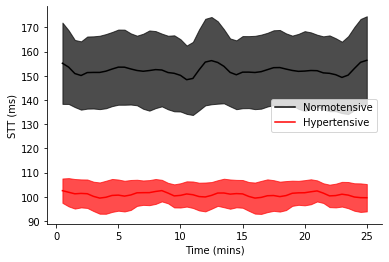

In [34]:
stat_v_time(STTs,'STT (ms)')

In [14]:
from scipy import stats
def hist_plot(stat,s_name,x_lab):
    '''
    Plot histogram distribution of values and compute KS stat
    '''
    norm = []
    hyp = []
    for key, value in stat.items():
        
        #Remove NaN values
        t = np.array(stat[key])
        t /= 1000
        t = t[np.logical_not(np.isnan(t))]
        if class_labels[key] == 0:
            norm.append(t)
        else:
            hyp.append(t)
    
    fig = plt.figure(figsize=(12,4))
    sns.distplot(np.hstack(norm),color='k',bins=100,norm_hist=True,label='Normotensive')
    sns.distplot(np.hstack(hyp),color='r',bins=100,norm_hist=True,label='Hypertensive')
    plt.title(s_name)
    plt.ylabel('Proportion of total')
    plt.xlabel(x_lab)
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    plt.legend()
    
    print(stats.ks_2samp(np.hstack(norm),np.hstack(hyp)))

Ks_2sampResult(statistic=0.5819553072625698, pvalue=1.0)


(0, 350)

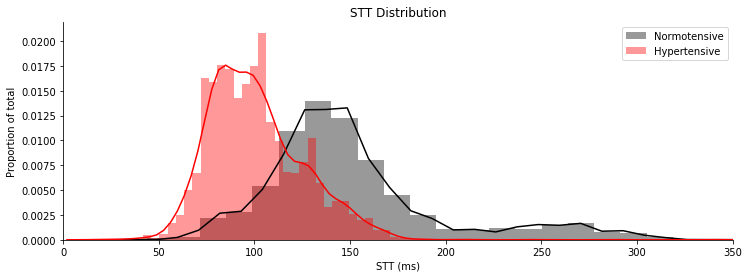

In [15]:
hist_plot(STTs,'STT Distribution','STT (ms)')
plt.xlim([0,350])

Ks_2sampResult(statistic=0.20049392666834098, pvalue=1.3176637558842685e-10)


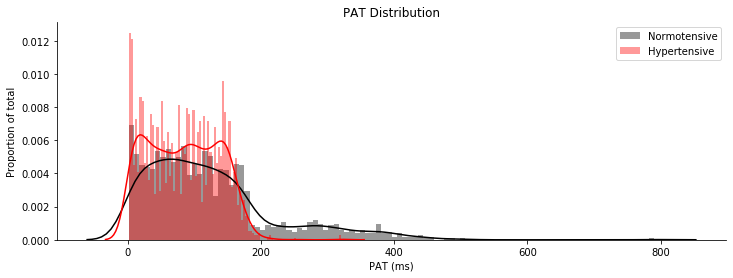

In [16]:
hist_plot(PATs,'PAT Distribution', 'PAT (ms)')

In [17]:
def plot_boxplot(stat,y_lab):
    '''
    Plot histogram distribution of values and compute KS stat
    '''
    norm = []
    hyp = []
    for key, value in stat.items():
        
        #Remove NaN values
        t = np.array(stat[key])
        t /= 1000
        t = t[np.logical_not(np.isnan(t))]
        if class_labels[key] == 0:
            norm.append(t)
        else:
            hyp.append(t)
    
    norm = np.hstack(norm)
    hyp = np.hstack(hyp)
    
    ax = plt.figure(figsize=(4,6))
    plt.boxplot([norm,hyp],notch=True,labels=['Normotensive','Hypertensive'])
    plt.ylabel(y_lab)
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    plt.legend()
    
    print(stats.bartlett(norm,hyp))

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


BartlettResult(statistic=2591.8356269157575, pvalue=0.0)


(0, 400)

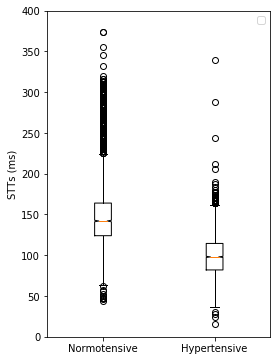

In [18]:
plot_boxplot(STTs,'STTs (ms)')
plt.ylim([0,400])

### What about waveform amplitude?

In [19]:
#Computes amplitude
amps = {}
for key,value in peak_dfs.items():
    
    #Compute a PAT array
    a = wm.P1_Amp(ppg_sigs[key],ts[key],peak_dfs[key])
    
    if class_labels[key] == -1:
        continue
    else:
        amps[key] = a

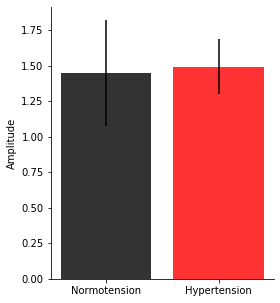

In [20]:
plot_bar(amps,'Amplitude')

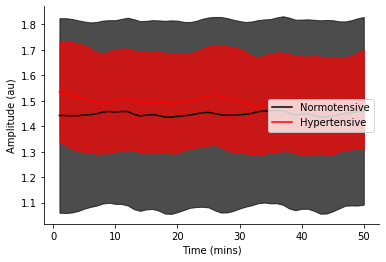

In [21]:
stat_v_time(amps,'Amplitude (au)')

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


BartlettResult(statistic=345.87018905524997, pvalue=3.3610850864139185e-77)


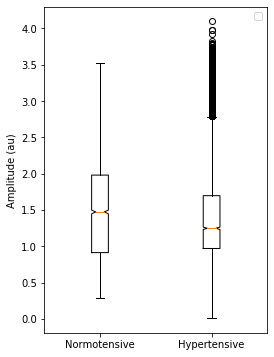

In [22]:
plot_boxplot(amps,'Amplitude (au)')

### The slope of a PPG wave might tell us something about its dynamics. 
Here I use the derivative of the signal to identify the peak of the slope prior to the main peak

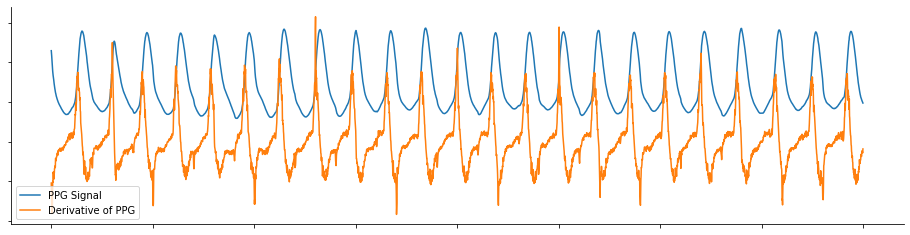

In [23]:
#Computing slope
fig = plt.figure(figsize=(16,4))
plt.plot(ppg_sig[0:4000],label='PPG Signal')

ppg_d = np.gradient(ppg_sig)
plt.plot(ppg_d[0:4000]*20,label='Derivative of PPG')

ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.legend()

In [24]:
#Compute PAT arrays and add to dict
slopes = {}
for key,value in peak_dfs.items():
    
    #Compute a PAT array
    s = wm.ppg_slope(ppg_sigs[key],peak_dfs[key],ts[key])
    
    if class_labels[key] == -1:
        continue
    else:
        slopes[key] = s

In [25]:
slopes

{'D43': array([2141., 1916., 2047., ...,   nan,   nan, 1462.]),
 'D44': array([2486., 2023., 2119., ...,   nan,   nan,   nan]),
 'D45': array([1994., 2042., 2346., ..., 2642., 2591., 2555.]),
 'D46': array([2646., 1785., 1562., ..., 1834., 1723., 1782.])}

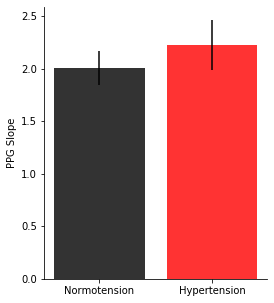

In [26]:
plot_bar(slopes,'PPG Slope')

Ks_2sampResult(statistic=0.1597330085972936, pvalue=1.0)


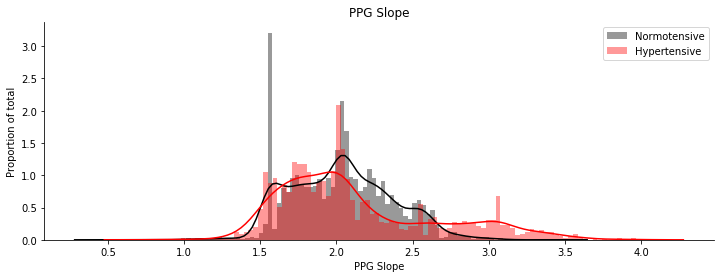

In [27]:
hist_plot(slopes,'PPG Slope','PPG Slope')

## Dicrotic Notch
### The Dicrotic notch marks the end of systole and start of diastole and thus could serve an important analysis purpose
* In several participants this notch is hard to make out
* A Chebyshev filter with the right parameters can enhance the notch so it can be more easily identified for subsequent analysis

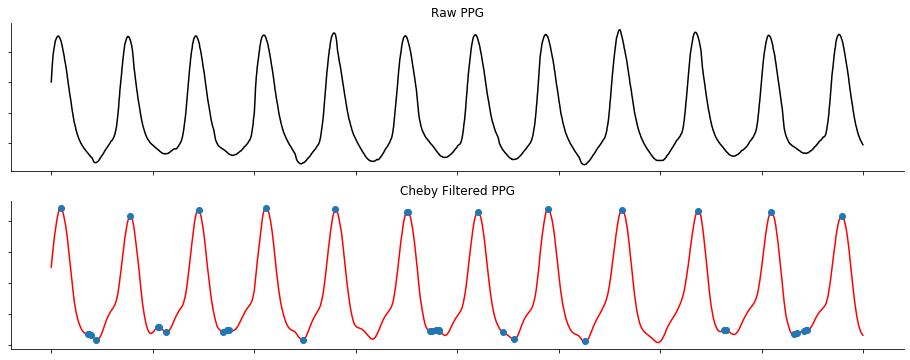

In [28]:
sos = signal.cheby2(10, 5, [0.5,5], 'bp', fs=250, output='sos')
filtered = signal.sosfilt(sos, ppg_sig)

fig = plt.figure(figsize=(16,6))

plt.subplot(2,1,1)
plt.plot(ppg_sig[2000:4000],'k')
plt.title('Raw PPG')
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.subplot(2,1,2)
plt.plot(filtered[2000:4000],'r')
plt.title('Cheby Filtered PPG')
ax = fig.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])

# f_peaks = signal.find_peaks(filtered)
# plt.plot(f_peaks[0][(f_peaks[0]>2000)&(f_peaks[0]<4000)]-2000,
#          filtered[f_peaks[0][(f_peaks[0]>2000)&(f_peaks[0]<4000)]],'o')

In [29]:
#Compute PAT arrays and add to dict
d_notchs = {}
for key,value in peak_dfs.items():
    
    #Compute a PAT array
    dn = wm.d_notch(ppg_sigs[key],peak_dfs[key],ts[key])
    
    if class_labels[key] == -1:
        continue
    else:
        d_notchs[key] = dn

### Let's look at the time from PPG peak to diastolic notch

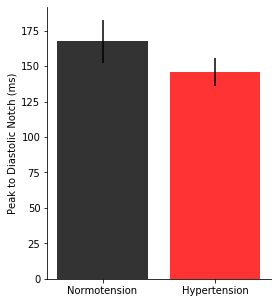

In [30]:
plot_bar(d_notchs,'Peak to Diastolic Notch (ms)')

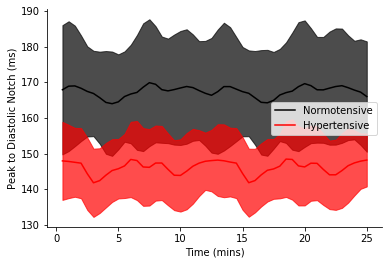

In [35]:
stat_v_time(d_notchs,'Peak to Diastolic Notch (ms)')